## Import & loading data

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [45]:
primary_energy      = pd.read_csv("https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv", low_memory = False)
power_plant         = pd.read_csv("https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/global_power_plant_database_last.csv", low_memory = False)
share_elec_prod     = pd.read_csv("https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-elec-produc-by-source.csv", low_memory = False)
share_energy_consum = pd.read_csv("https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-energy-consum-by-source.csv", low_memory = False)
population          = pd.read_csv("https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/population-by-country.csv", low_memory = False)
pop_2020            = pd.read_csv("https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/population_by_country_2020.csv")

# Pre processing

### Total Population Dataset units: thousands of inhabitants over the years

In [46]:
pop_2020.rename(columns = {'Country (or dependency)': "Entity", "Population (2020)": "population"}, inplace = True)
pop_2020["Year"] = 2020
pop_2020 = pop_2020[["Entity", "Year", "population"]]

In [47]:
#population["Total population (Fink-Jensen 2015)"].max()
#np.sort(population.Year.unique())
population.rename(columns = {"Total population (Fink-Jensen 2015)": "population"}, inplace = True)
population = population[population.Entity.isin(pop_2020.Entity)]
population.population = population.population * 1e3 # units
population = population[["Entity", "Year", "population"]]
pop_2020 = pop_2020[pop_2020.Entity.isin(population.Entity)]
pop_2020 = pd.concat([population, pop_2020])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [48]:
pop_2020[pop_2020.Year == 2020]

,Entity,Year,population
0,China,2020,1.440298e+09
1,India,2020,1.382345e+09
2,United States,2020,3.313410e+08
4,Pakistan,2020,2.216128e+08
5,Brazil,2020,2.128220e+08
...,...,...,...
216,Liechtenstein,2020,3.814700e+04
217,San Marino,2020,3.394400e+04
221,Palau,2020,1.810900e+04
224,Tuvalu,2020,1.181700e+04


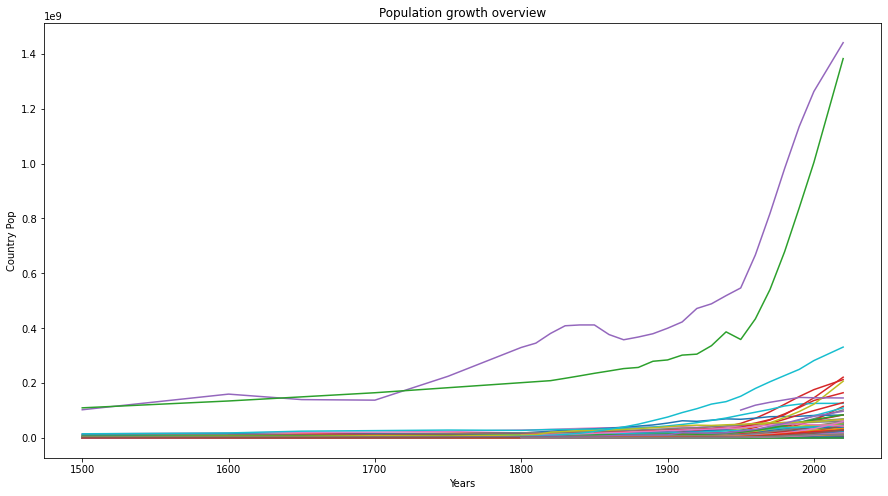

In [49]:
entities = pop_2020.Entity.unique()
years = np.sort(pop_2020.Year.unique())

groups = pop_2020.groupby("Entity")

# entity_dic = {entity:population.loc[population.Entity == entity] for entity in entities}
fig = plt.figure(figsize=(15,8))
for ent in entities:
  now_df = groups.get_group(ent)
  plt.plot(now_df.Year, now_df.population, label = ent)
plt.xlabel("Years")
plt.ylabel("Country Pop")
plt.title("Population growth overview")
plt.show()

#### filling values

Err: 56


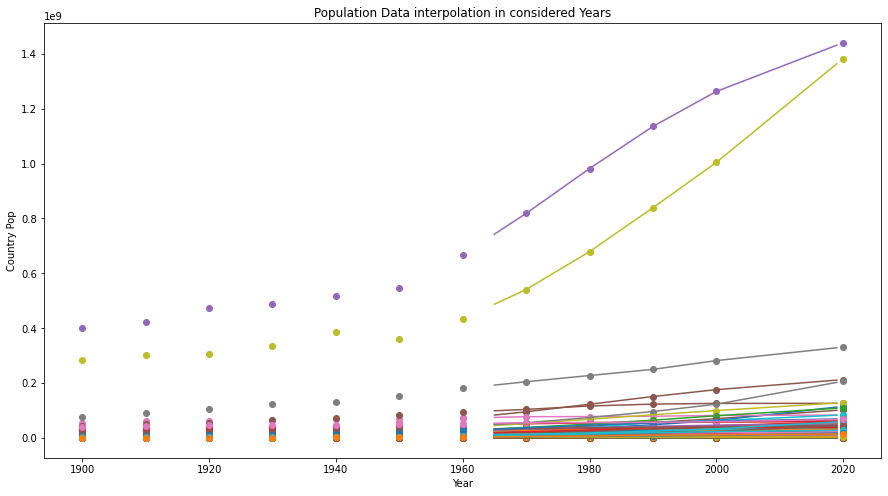

In [50]:
needed_years = np.sort(share_energy_consum.Year.unique())
plot_years = years[years >= 1900]
fig = plt.figure(figsize=(15,8))
population_df_final = pd.DataFrame(columns = ["Entity", "Year", "population"])
errcount = 0
for ent in entities:
  now_df = groups.get_group(ent)
  #print(val[val.Year.isin(plot_years)])
  interpolator = interpolate.interp1d(now_df.Year, now_df.population)
  interpolation = interpolator(needed_years)
  temp = pd.DataFrame({"Year": needed_years, "population": interpolation})
  temp["Entity"] = ent
  population_df_final = population_df_final.append(temp)
  try:
    plt.scatter(plot_years, now_df[now_df.Year.isin(plot_years)].population, label = ent)
    plt.plot(needed_years, interpolation)
  except:
    errcount += 1

print("Err:", errcount)

del temp
population_df_final = population_df_final.reset_index()
plt.title("Population Data interpolation in considered Years")
plt.ylabel("Country Pop")
plt.xlabel("Year")
plt.show()

In [51]:
population_df_final.Year.unique()

array([1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=object)

## Power Plant processing

In [52]:
power_plant.head(1)

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.322,65.119,Hydro,NaN,NaN,...,123.77,162.9,97.39,137.76,119.5,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


In [53]:
power_plant.rename(columns = {"country_long":"Entity"}, inplace = True)
power_plant = power_plant[["Entity", "capacity_mw", "primary_fuel"] + list(
    filter(lambda x: "generation_" in x and not "note" in x and not "source" in x, power_plant.columns)
)]
years = sorted(list(set([spl.split("_")[-1] for spl in list(filter(lambda x: "generation_" in x, power_plant.columns))])))
power_plant.head()

,Entity,capacity_mw,primary_fuel,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017
0,Afghanistan,33.0,Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.77,162.90,97.39,137.76,119.50
1,Afghanistan,10.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.43,17.48,18.25,17.70,18.29
2,Afghanistan,10.0,Solar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.64,17.58,19.10,17.62,18.72
3,Afghanistan,66.0,Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.06,203.55,146.90,230.18,174.91
4,Afghanistan,100.0,Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,406.16,357.22,270.99,395.38,350.80


In [54]:
for i in years:
  if(i == "2018" or i == "2019"):
    power_plant[i] = power_plant[f"generation_gwh_{i}"]
  else:
    power_plant[i] = power_plant[f"generation_gwh_{i}"].fillna(power_plant[f"estimated_generation_gwh_{i}"])

power_plant = power_plant[["Entity", "capacity_mw",	"primary_fuel"] + years]
#power_plant = power_plant.fillna(power_plant[["y"+y for y in years]].mean(axis = 1), axis = 1)
power_plant = power_plant.apply(lambda row: row.fillna(row[years].mean()), axis=1)
power_plant.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Entity,capacity_mw,primary_fuel,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,33.0,Hydro,123.77,162.90,97.39,137.76,119.50,128.264,128.264
1,Afghanistan,10.0,Solar,18.43,17.48,18.25,17.70,18.29,18.030,18.030
2,Afghanistan,10.0,Solar,18.64,17.58,19.10,17.62,18.72,18.332,18.332
3,Afghanistan,66.0,Hydro,225.06,203.55,146.90,230.18,174.91,196.120,196.120
4,Afghanistan,100.0,Hydro,406.16,357.22,270.99,395.38,350.80,356.110,356.110


In [55]:
primary_fuels   = power_plant.primary_fuel.unique()
renewable_fuels = ['Hydro', 'Solar', 'Wind', 'Waste', 'Biomass', 'Wave and Tidal', 'Geothermal', 'Cogeneration']
nuclear_fuels   = ['Nuclear']
fossil_fuels    = ['Gas', 'Other', 'Oil', 'Petcoke']

In [56]:
power_plant_groups = power_plant.groupby(["Entity", "primary_fuel"]).sum().reset_index().groupby("Entity")
power_plant_groups.get_group("Italy")

,Entity,primary_fuel,capacity_mw,2013,2014,2015,2016,2017,2018,2019
307,Italy,Coal,9012.00,35419.808000,35419.808000,40862.116,34173.4910,32268.592,34375.033000,35419.808000
308,Italy,Gas,38570.65,89290.890167,89290.890167,70609.052,89072.0415,108191.577,89290.890167,89290.890167
309,Italy,Geothermal,857.00,5679.248667,5679.248667,5679.236,5692.4700,5666.040,5679.248667,5679.248667
310,Italy,Hydro,13384.18,31042.330000,37332.990000,18504.103,23724.9510,15796.800,25280.234800,25280.234800
311,Italy,Oil,8828.70,10620.796667,10620.796667,10771.267,10672.5880,10418.535,10620.796667,10620.796667
312,Italy,Other,384.60,1329.930333,1329.930333,1132.640,1367.2100,1489.941,1329.930333,1329.930333
313,Italy,Solar,1952.69,3412.780000,3381.940000,5618.605,5702.7060,5614.512,4746.108600,4746.108600
314,Italy,Wind,105.24,191.760000,191.760000,191.760,191.7600,191.760,191.760000,191.760000


In [57]:
gwh_yearly = power_plant_groups.sum().reset_index().melt(id_vars = ["Entity", "capacity_mw"], var_name="Year", value_vars=years)
gwh_yearly.rename(columns = {"value": "gwh_prod"}, inplace = True)
gwh_yearly.head()

,Entity,capacity_mw,Year,gwh_prod
0,Afghanistan,300.55,2013,996.05
1,Albania,1529.00,2013,5259.64
2,Algeria,15873.80,2013,64561.66
3,Angola,1071.18,2013,2720.37
4,Antarctica,7.60,2013,0.00


## Merging Datasets

In [58]:
inner_res = gwh_yearly.astype({"Year":"int32"}).merge(population_df_final.astype({"Year":"int32"}), how="inner", on=["Entity", "Year"])
inner_res[inner_res.Entity == "Italy"].head(10)

,Entity,capacity_mw,Year,gwh_prod,index,population
65,Italy,73095.06,2013,176987.543833,48,59491690.7
214,Italy,73095.06,2014,183247.363833,49,59628025.6
363,Italy,73095.06,2015,153368.779000,50,59764360.5
512,Italy,73095.06,2016,170597.217500,51,59900695.4
661,Italy,73095.06,2017,179637.757000,52,60037030.3
810,Italy,73095.06,2018,171514.002233,53,60173365.2
959,Italy,73095.06,2019,172558.777233,54,60309700.1


In [59]:
try:
  primary_energy.rename(columns={
      "Fossil fuels (% sub energy)": "Fossil",
      "Renewables (% sub energy)": "Renewables",
      "Nuclear (% sub energy)": "Nuclear"
  }, inplace = True)

  primary_energy.drop("Code", axis = 1, inplace = True)
except:
  pass
finally:
  tot = primary_energy.astype({"Year":"int32"}).merge(inner_res, how="right", on=["Entity", "Year"])

In [60]:
tot["Fossil_gwh"] = tot["Fossil"] * tot["gwh_prod"] / 100
tot["Renewables_gwh"] = tot["Renewables"] * tot["gwh_prod"] / 100
tot["Nuclear_gwh"] = tot["Nuclear"] * tot["gwh_prod"] / 100

tot["Fossil_procapite_wh"] = 1e6 * tot["Fossil_gwh"] / tot["population"]
tot["Renewables_procapite_wh"] = 1e6 * tot["Renewables_gwh"] / tot["population"] 
tot["Nuclear_procapite_wh"] = 1e6 * tot["Nuclear_gwh"] / tot["population"] 

In [61]:
dataset = tot.dropna()
dataset.head()

,Entity,Year,Fossil,Renewables,Nuclear,capacity_mw,gwh_prod,index,population,Fossil_gwh,Renewables_gwh,Nuclear_gwh,Fossil_procapite_wh,Renewables_procapite_wh,Nuclear_procapite_wh
2,Algeria,2013,99.939,0.061,0.000,15873.800,64561.660000,48,39240119.85,64522.277387,39.382613,0.000000,1644.293586,1.003631,0.000000
4,Argentina,2013,85.737,12.640,1.623,32913.079,136407.680000,48,42491441.85,116951.852602,17241.930752,2213.896646,2752.362535,405.774198,52.102178
6,Australia,2013,93.140,6.860,0.000,65852.016,269295.690139,48,23276493.95,250822.005795,18473.684344,0.000000,10775.764010,793.662670,0.000000
7,Austria,2013,66.523,33.477,0.000,11227.100,36744.001000,48,8699679.20,24443.211785,12300.789215,0.000000,2809.668175,1413.935955,0.000000
8,Azerbaijan,2013,97.399,2.601,0.000,5764.000,21760.290000,48,9333885.70,21194.304857,565.985143,0.000000,2270.683994,60.637677,0.000000


In [62]:
columns = ["Entity", "capacity_mw", "Fossil_gwh", "Renewables_gwh", "Nuclear_gwh", "Fossil_procapite_wh", "Renewables_procapite_wh", "Nuclear_procapite_wh"]
dataset = dataset[columns]
dataset.head()

,Entity,capacity_mw,Fossil_gwh,Renewables_gwh,Nuclear_gwh,Fossil_procapite_wh,Renewables_procapite_wh,Nuclear_procapite_wh
2,Algeria,15873.800,64522.277387,39.382613,0.000000,1644.293586,1.003631,0.000000
4,Argentina,32913.079,116951.852602,17241.930752,2213.896646,2752.362535,405.774198,52.102178
6,Australia,65852.016,250822.005795,18473.684344,0.000000,10775.764010,793.662670,0.000000
7,Austria,11227.100,24443.211785,12300.789215,0.000000,2809.668175,1413.935955,0.000000
8,Azerbaijan,5764.000,21194.304857,565.985143,0.000000,2270.683994,60.637677,0.000000


In [63]:
for col in dataset.columns[1:]:
  dataset[col] = dataset[col] / dataset[col].max()

In [64]:
dataset.head()

,Entity,capacity_mw,Fossil_gwh,Renewables_gwh,Nuclear_gwh,Fossil_procapite_wh,Renewables_procapite_wh,Nuclear_procapite_wh
2,Algeria,0.011218,0.011631,0.000050,0.000000,0.063924,0.000063,0.000000
4,Argentina,0.023259,0.021083,0.022037,0.010717,0.107001,0.025391,0.015531
6,Australia,0.046536,0.045216,0.023612,0.000000,0.418919,0.049662,0.000000
7,Austria,0.007934,0.004406,0.015722,0.000000,0.109229,0.088475,0.000000
8,Azerbaijan,0.004073,0.003821,0.000723,0.000000,0.088275,0.003794,0.000000


# Clustering

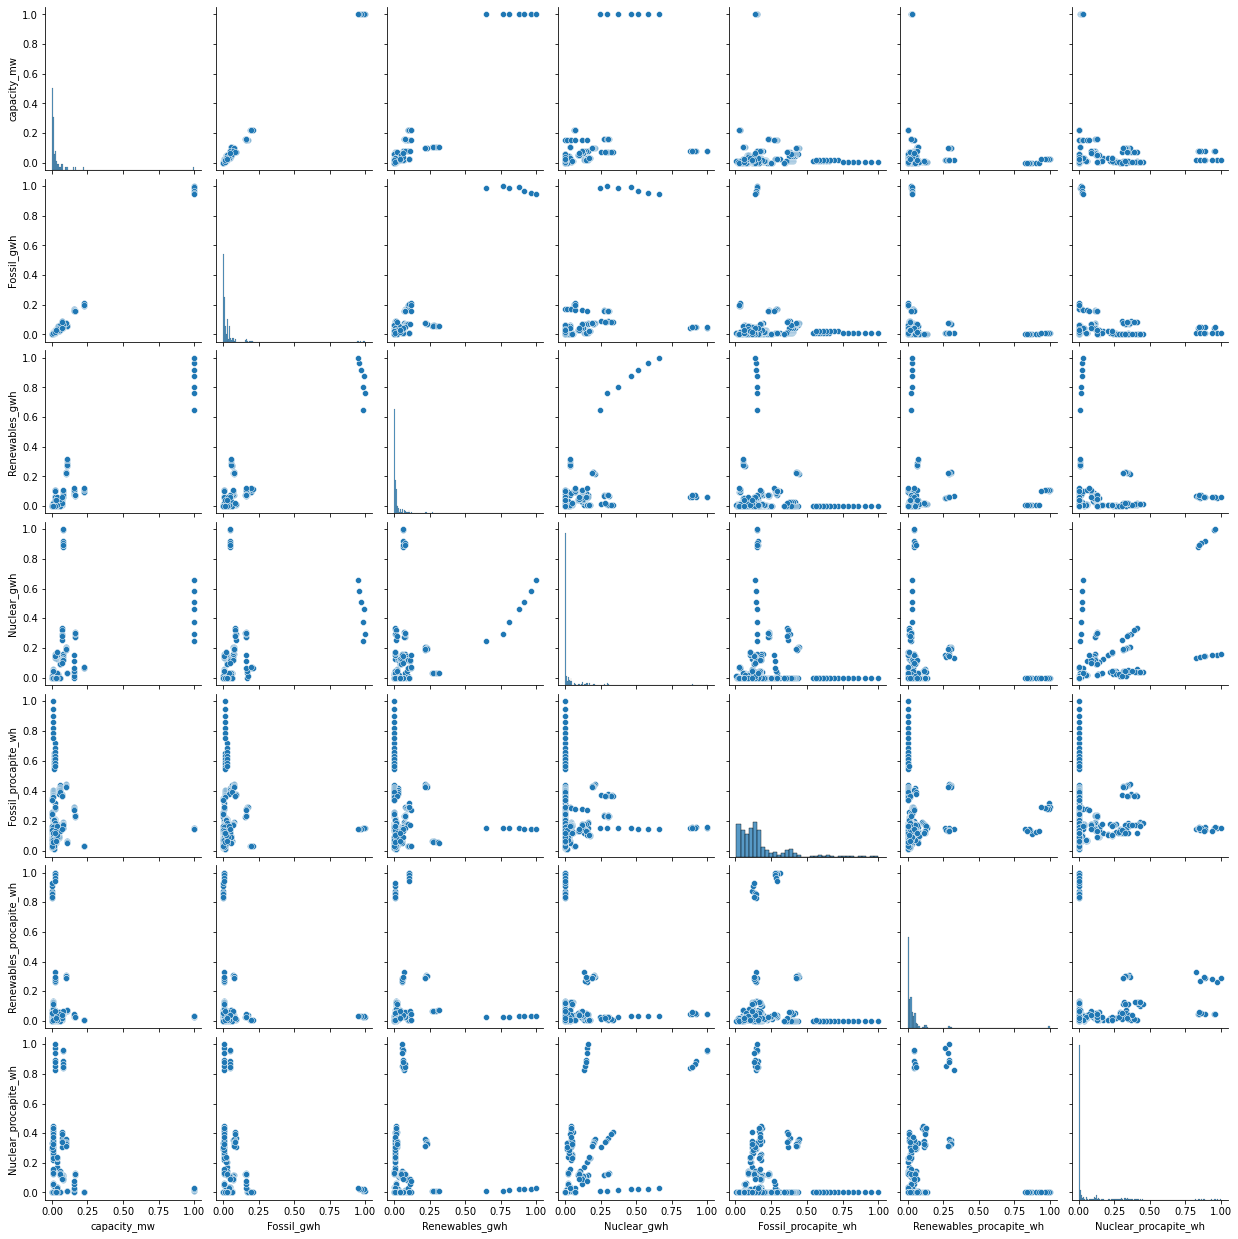

In [65]:
sns.pairplot(dataset[dataset.columns[1:]], palette = "Accent")
plt.show()

## KMEANS

Using columns: capacity_mw Fossil_gwh Renewables_gwh Nuclear_gwh Fossil_procapite_wh Renewables_procapite_wh Nuclear_procapite_wh
Tested kMeans with k = 2	SS: 0.8056
Tested kMeans with k = 3	SS: 0.6505
Tested kMeans with k = 4	SS: 0.6622
Tested kMeans with k = 5	SS: 0.5621
Tested kMeans with k = 6	SS: 0.5693
Tested kMeans with k = 7	SS: 0.5953
Tested kMeans with k = 8	SS: 0.5772
Tested kMeans with k = 9	SS: 0.5682
Tested kMeans with k = 10	SS: 0.5944
Tested kMeans with k = 11	SS: 0.4664
Tested kMeans with k = 12	SS: 0.4748
Tested kMeans with k = 13	SS: 0.4953
Tested kMeans with k = 14	SS: 0.5058
Tested kMeans with k = 15	SS: 0.5112
Tested kMeans with k = 16	SS: 0.4954
Tested kMeans with k = 17	SS: 0.5290
Tested kMeans with k = 18	SS: 0.5026
Tested kMeans with k = 19	SS: 0.5328


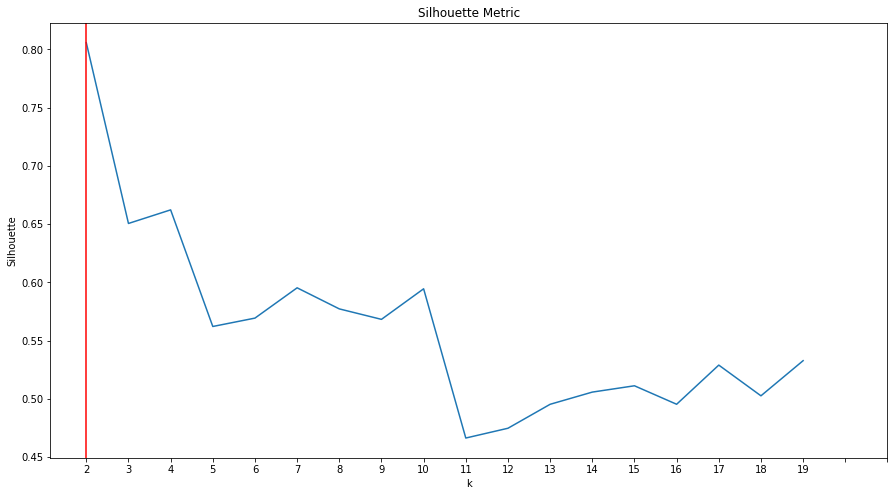

In [66]:
dataset_clustering = dataset[dataset.columns[1:]]
silhouette_scores = {}
print("Using columns:", *dataset_clustering.columns)
for k in range(2,20):
  model_kmeans_k = KMeans( n_clusters = k, random_state = 11 )
  model_kmeans_k.fit(dataset_clustering)
  labels_k = model_kmeans_k.labels_
  score_k = metrics.silhouette_score(dataset_clustering, labels_k)
  silhouette_scores[k] = score_k
  print("Tested kMeans with k = %d\tSS: %5.4f" % (k, score_k))
plt.figure(figsize = (15,8))
plt.plot(list(silhouette_scores.values()))
plt.xticks(range(0,20), silhouette_scores.keys())
plt.title("Silhouette Metric")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.axvline(0, color = "r")
plt.show()

Using columns: capacity_mw Fossil_gwh Renewables_gwh Nuclear_gwh Fossil_procapite_wh Renewables_procapite_wh Nuclear_procapite_wh
Tested kMeans with k = 2	SS: 50.1792
Tested kMeans with k = 3	SS: 35.9122
Tested kMeans with k = 4	SS: 25.4532
Tested kMeans with k = 5	SS: 17.2059
Tested kMeans with k = 6	SS: 11.9655
Tested kMeans with k = 7	SS: 9.6033
Tested kMeans with k = 8	SS: 7.8529
Tested kMeans with k = 9	SS: 6.2869
Tested kMeans with k = 10	SS: 4.9378
Tested kMeans with k = 11	SS: 4.2547
Tested kMeans with k = 12	SS: 3.7497
Tested kMeans with k = 13	SS: 3.1294
Tested kMeans with k = 14	SS: 2.7074
Tested kMeans with k = 15	SS: 2.4336
Tested kMeans with k = 16	SS: 2.1798
Tested kMeans with k = 17	SS: 1.9511
Tested kMeans with k = 18	SS: 1.7797
Tested kMeans with k = 19	SS: 1.5627


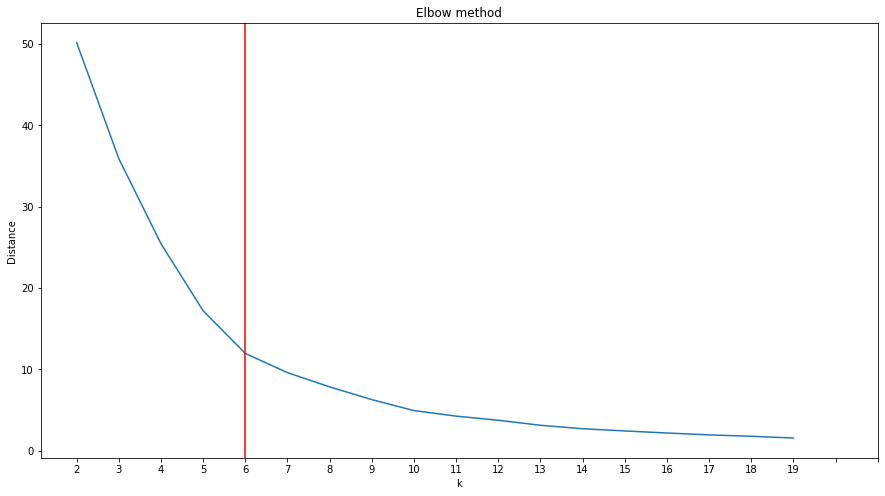

In [67]:
distances = {}
print("Using columns:", *dataset_clustering.columns)
for k in range(2,20):
  model_kmeans_k = KMeans( n_clusters = k, random_state = 11 )
  model_kmeans_k.fit(dataset_clustering)
  #labels_k = model_kmeans_k.labels_
  #score_k = metrics.silhouette_score(dataset_clustering, labels_k)
  distances[k] = model_kmeans_k.inertia_
  print("Tested kMeans with k = %d\tSS: %5.4f" % (k, distances[k]))
plt.figure(figsize = (15,8))
plt.plot(list(distances.values()))
plt.xticks(range(0,20), distances.keys())
plt.title("Elbow method")
plt.xlabel("k")
plt.ylabel("Distance")
plt.axvline(4, color = "r")
plt.show()

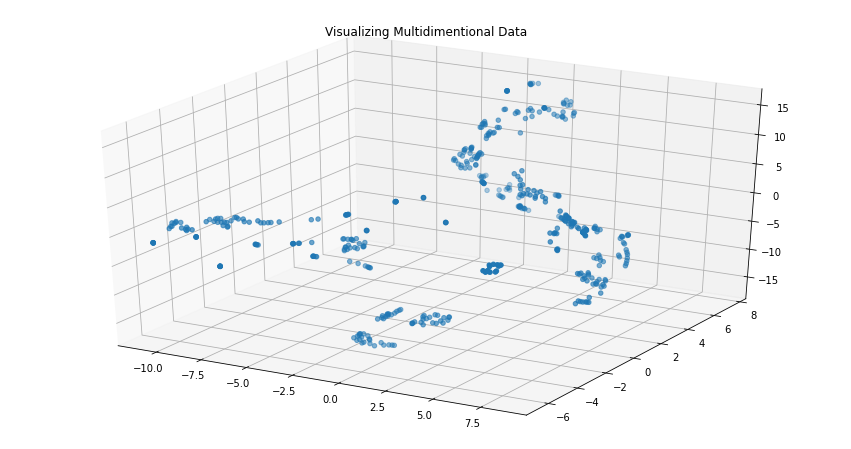

In [68]:
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(dataset_clustering)

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(projection = "3d")
ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2])
plt.title("Visualizing Multidimentional Data")
plt.show()

In [69]:
Kmeans = KMeans( n_clusters = 6, random_state = 11 )
Kmeans.fit(dataset_clustering)
labels = Kmeans.labels_
dataset["LABEL_KMEANS"] = labels
dataset.head()

,Entity,capacity_mw,Fossil_gwh,Renewables_gwh,Nuclear_gwh,Fossil_procapite_wh,Renewables_procapite_wh,Nuclear_procapite_wh,LABEL_KMEANS
2,Algeria,0.011218,0.011631,0.000050,0.000000,0.063924,0.000063,0.000000,0
4,Argentina,0.023259,0.021083,0.022037,0.010717,0.107001,0.025391,0.015531,0
6,Australia,0.046536,0.045216,0.023612,0.000000,0.418919,0.049662,0.000000,5
7,Austria,0.007934,0.004406,0.015722,0.000000,0.109229,0.088475,0.000000,0
8,Azerbaijan,0.004073,0.003821,0.000723,0.000000,0.088275,0.003794,0.000000,0


In [70]:
dataset.groupby("LABEL_KMEANS").count()

,Entity,capacity_mw,Fossil_gwh,Renewables_gwh,Nuclear_gwh,Fossil_procapite_wh,Renewables_procapite_wh,Nuclear_procapite_wh
LABEL_KMEANS,,,,,,,,
0,334,334,334,334,334,334,334,334
1,86,86,86,86,86,86,86,86
2,14,14,14,14,14,14,14,14
3,7,7,7,7,7,7,7,7
4,14,14,14,14,14,14,14,14
5,56,56,56,56,56,56,56,56


##DBSCAN

In [31]:
def get_metrics(eps, min_samples, dataset, iter_):
  
  # Fitting ======================================================================
  
  dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
  dbscan_model_.fit(dataset)
  
  # Mean Noise Point Distance metric =============================================
  noise_indices = dbscan_model_.labels_ == -1
  
  if True in noise_indices:
    neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
    distances, indices = neighboors.kneighbors(dataset)
    noise_distances = distances[noise_indices, 1:]
    noise_mean_distance = round(noise_distances.mean(), 3)
  else:
    noise_mean_distance = None
      
  # Number of found Clusters metric ==============================================
  
  number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
  
  # Log ==========================================================================
  
  print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
      
  return(noise_mean_distance, number_of_clusters)

In [32]:
eps_to_test = [round(eps,1) for eps in np.arange(0.1, 2, 0.1)]
min_samples_to_test = range(5, 50, 5)

In [33]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
  data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
  columns = min_samples_to_test, 
  index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
  data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
  columns = min_samples_to_test, 
  index = eps_to_test
)

In [34]:
dataset_clustering

,capacity_mw,Fossil_gwh,Renewables_gwh,Nuclear_gwh,Fossil_procapite_wh,Renewables_procapite_wh,Nuclear_procapite_wh
2,0.011218,0.011631,0.000050,0.000000,0.063924,0.000063,0.000000
4,0.023259,0.021083,0.022037,0.010717,0.107001,0.025391,0.015531
6,0.046536,0.045216,0.023612,0.000000,0.418919,0.049662,0.000000
7,0.007934,0.004406,0.015722,0.000000,0.109229,0.088475,0.000000
8,0.004073,0.003821,0.000723,0.000000,0.088275,0.003794,0.000000
...,...,...,...,...,...,...,...
1034,0.021431,0.025060,0.001381,0.000000,0.564343,0.007058,0.000000
1035,0.068658,0.044834,0.058043,0.097160,0.143182,0.042081,0.088597
1037,0.008932,0.009558,0.002276,0.000000,0.062221,0.003364,0.000000
1038,0.021975,0.015967,0.038527,0.000000,0.122213,0.066945,0.000000


In [35]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
  for min_samples in min_samples_to_test:
    
    iter_ += 1
    
    # Calcolo le metriche
    noise_metric, cluster_metric = get_metrics(eps, min_samples, dataset_clustering, iter_)
    
    # Inserisco i risultati nei relativi dataframe
    results_noise.loc[eps, min_samples] = noise_metric
    results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.1 and min_samples =   5 | 0.182   12
  2 | Tested with eps = 0.1 and min_samples =  10 | 0.058    2
  3 | Tested with eps = 0.1 and min_samples =  15 | 0.054    3
  4 | Tested with eps = 0.1 and min_samples =  20 | 0.051    3
  5 | Tested with eps = 0.1 and min_samples =  25 | 0.046    2
  6 | Tested with eps = 0.1 and min_samples =  30 | 0.046    2
  7 | Tested with eps = 0.1 and min_samples =  35 | 0.042    2
  8 | Tested with eps = 0.1 and min_samples =  40 | 0.038    1
  9 | Tested with eps = 0.1 and min_samples =  45 | 0.038    1
 10 | Tested with eps = 0.2 and min_samples =   5 | 0.253    9
 11 | Tested with eps = 0.2 and min_samples =  10 | 0.066    2
 12 | Tested with eps = 0.2 and min_samples =  15 |  0.06    1
 13 | Tested with eps = 0.2 and min_samples =  20 | 0.061    1
 14 | Tested with eps = 0.2 and min_samples =  25

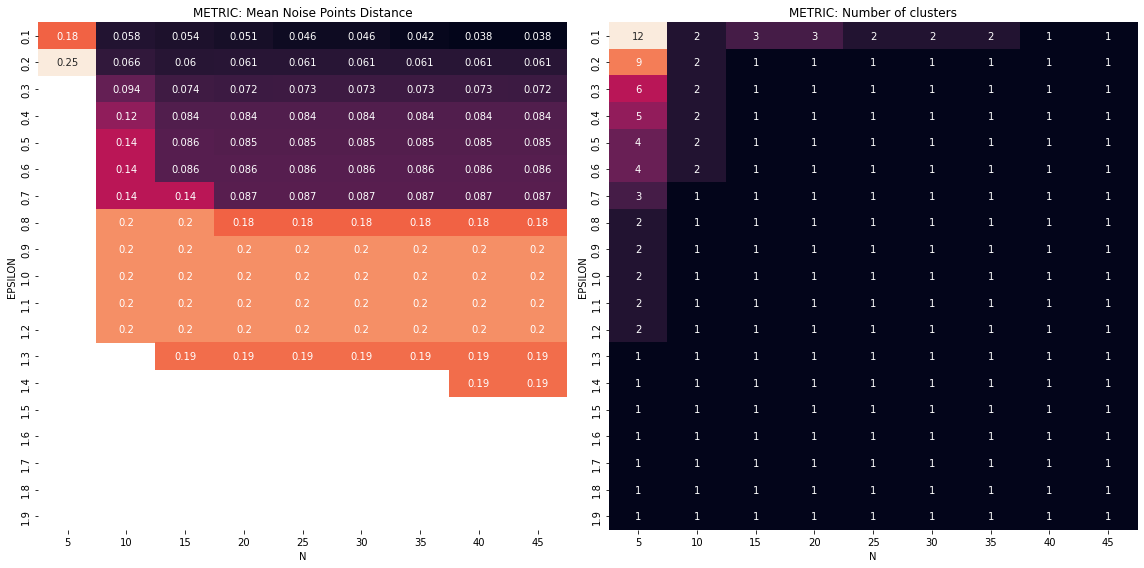

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

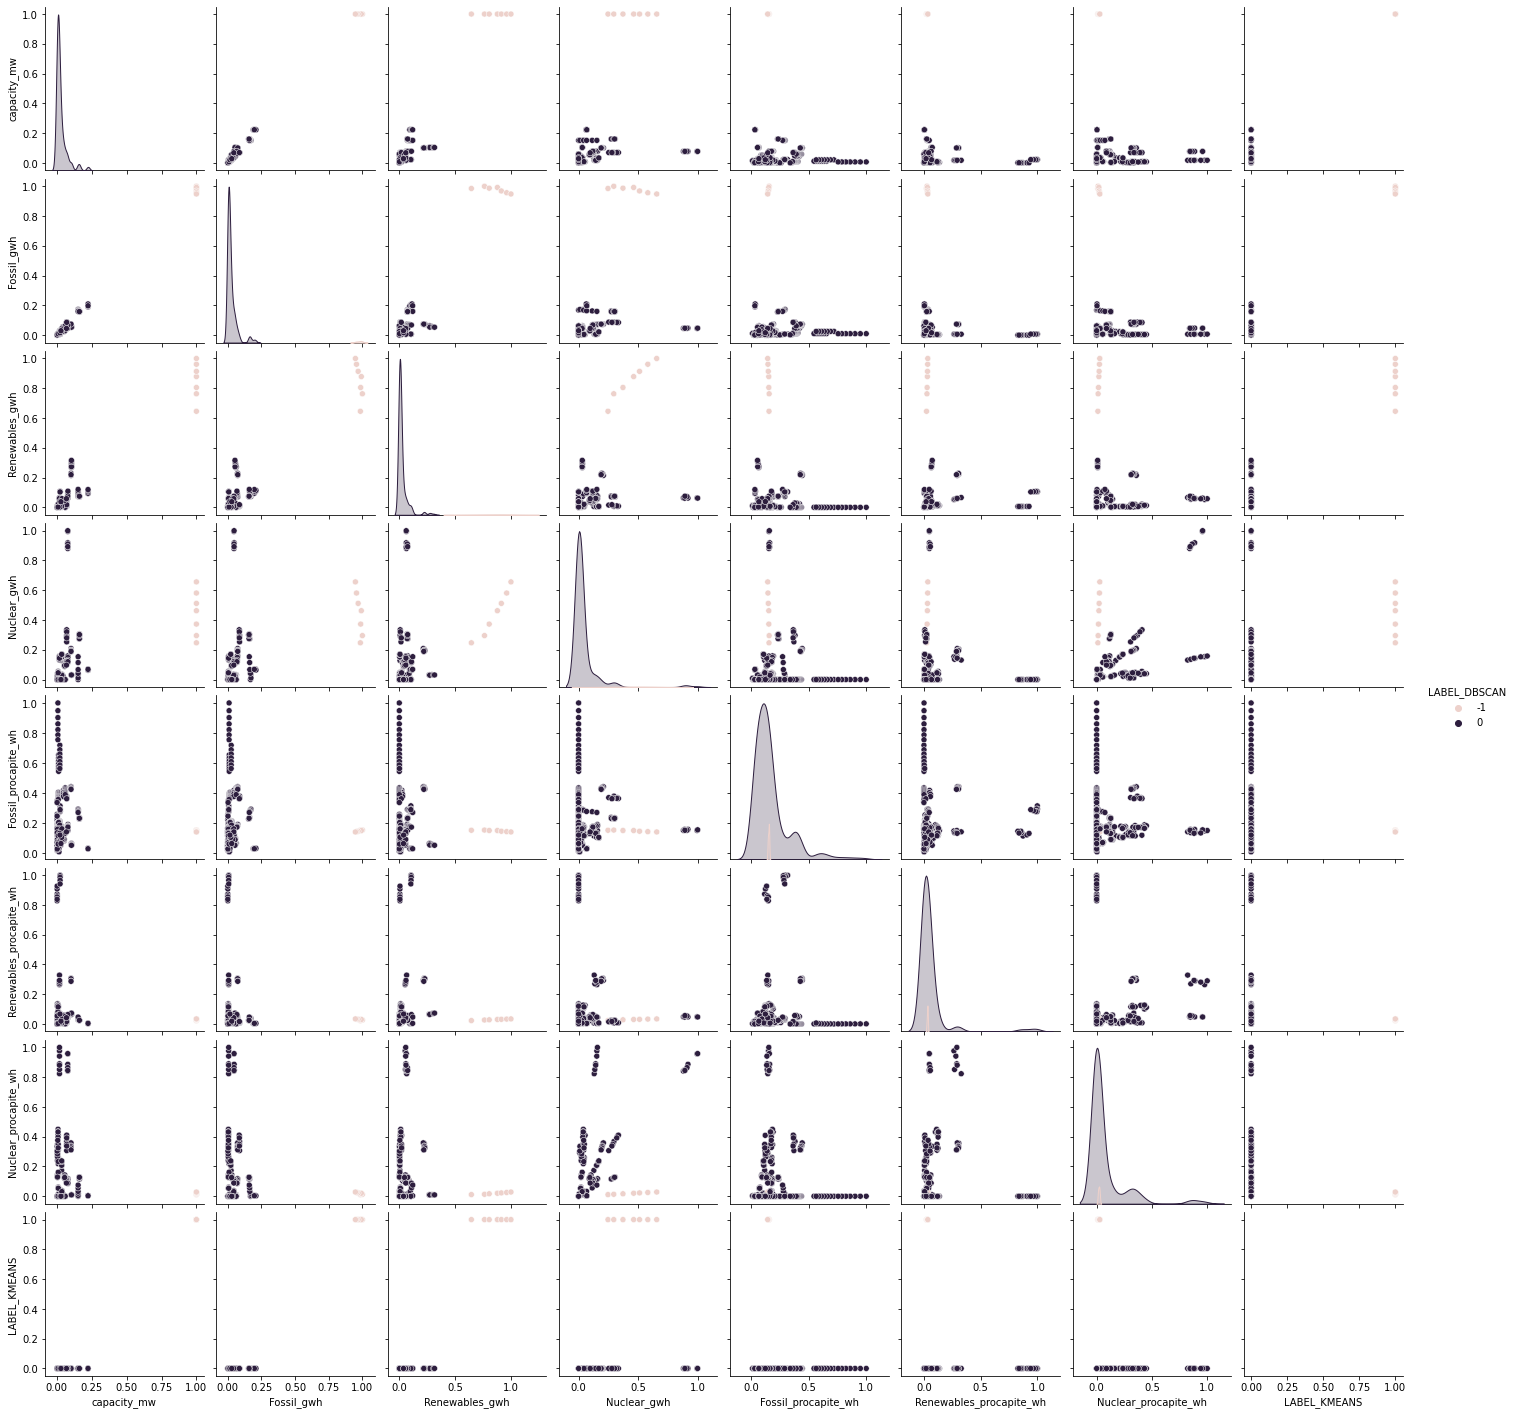

In [39]:
# Istantiating with eps = 1 and min_samples = 15 (best model)
best_dbscan_model = DBSCAN( eps = 0.8, min_samples = 10)

# Fitting
best_dbscan_model.fit(dataset_clustering)

# Extracting labels
dataset["LABEL_DBSCAN"] = best_dbscan_model.labels_

# Pairplot
sns.pairplot( dataset[dataset.columns[1:]], hue = "LABEL_DBSCAN" ); plt.show()

In [38]:
dataset.groupby("LABEL_DBSCAN").count()

,Entity,capacity_mw,Fossil_gwh,Renewables_gwh,Nuclear_gwh,Fossil_procapite_wh,Renewables_procapite_wh,Nuclear_procapite_wh,LABEL_KMEANS
LABEL_DBSCAN,,,,,,,,,
0,497,497,497,497,497,497,497,497,497
1,7,7,7,7,7,7,7,7,7
2,7,7,7,7,7,7,7,7,7
